In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Dropout, Input, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
tf.__version__

'2.9.2'

In [2]:
def load_data_batch(ids, batch_size, channel, path):
    
    '''
        This function create a batch of training data
    '''
    
    data = pd.read_csv(path + '/label.csv')

    path = path + '/'
    
    image_batch = np.zeros((batch_size, 448, 448, channel))
    
    label_major = np.zeros((batch_size, 1))
    label_minor = np.zeros((batch_size, 1))
    batch_ids = np.random.choice(ids, batch_size)
    
    ind = 0
    for i in range(1,len(batch_ids)):
        
        # if channel == 1:
        #     im = Image.open(path + str(batch_ids[i]) + '.jpg').convert('L')
        # else:
        im = Image.open(path + str(batch_ids[i]) + '.jpg')
            
        # im = im.resize((im_size,im_size), Image.ANTIALIAS)
        im = np.array(im)
        # print(im.shape)
        image_batch[ind] = im
        label_major[ind] = (data['Major_scale'][data.index==batch_ids[i]])
        label_minor[ind] = (data['Minor_scale'][data.index==batch_ids[i]])
        ind += 1
            
    return (np.array(image_batch), np.array(label_major), np.array(label_minor))

In [3]:
data_num = 1886
data_ids = np.arange(data_num)+1  # image data starts with 1
data_ids[:5]

array([1, 2, 3, 4, 5])

In [8]:
# Run this chunk code when it occurs error on load_data_batch() function
label_major = np.zeros((20, 1))
label_major[0] = 1
label_major

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [9]:
X_data, y1_data, y2_data = load_data_batch(ids=data_ids,
                                           batch_size=len(data_ids),
                                           channel=3,
                                           path="../Gauge_classification/gauges_44")

In [11]:
X_df = pd.DataFrame(X_data, index=False)

ValueError: Must pass 2-d input. shape=(1886, 448, 448, 3)

In [16]:
X_data_norm = X_data/255.
X_data_norm[:2]

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [17]:
X_data_norm.shape

(1886, 448, 448, 3)

In [18]:
# split train test
num_train = math.ceil(len(y1_data) * 0.8)

X_train, X_test, y_class_train, y_train, y_class_test, y_test = X_data_norm[:num_train], X_data_norm[num_train:], y1_data[:num_train], y2_data[:num_train], y1_data[num_train:], y2_data[num_train:]

In [19]:
len(X_train), len(X_test)

(1509, 377)

In [20]:
len(y_class_train), len(y_class_test)

(1509, 377)

In [21]:
# Non-normalized
X_train1, X_test1, y_class_train1, y_train1, y_class_test1, y_test1 = X_data[:num_train], X_data[num_train:], y1_data[:num_train], y2_data[:num_train], y1_data[num_train:], y2_data[num_train:]

In [22]:
X_train1[:2]

array([[[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
       

#### Model1

In [25]:
#Create model
input = Input(shape = (448,448,3))
conv1 = Conv2D(50,3,activation='relu')(input)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(100,3,activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(150,3,activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(200,3,activation='relu')(pool2)
dropou4 = Dropout(.4)(conv4)

flat = Flatten()(pool2)

major = Dense(144, activation='relu')(flat)
major = Dense(144, activation='relu')(major)
major = Dense(5, activation='softmax', name="major")(major)

minor = Dense(100, activation='relu')(flat)
minor = Dense(200, activation='relu')(minor)
minor = Dense(1, activation='linear', name="minor")(minor)

model = Model(inputs=input, outputs=[major, minor])

2022-08-28 22:44:28.209378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-28 22:44:28.210669: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [26]:
adam = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(loss=["sparse_categorical_crossentropy", "mse"], 
              optimizer=adam,
              metrics=["accuracy", "mae"])

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 446, 446, 50  1400        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 223, 223, 50  0           ['conv2d[0][0]']                 
                                )                                                             

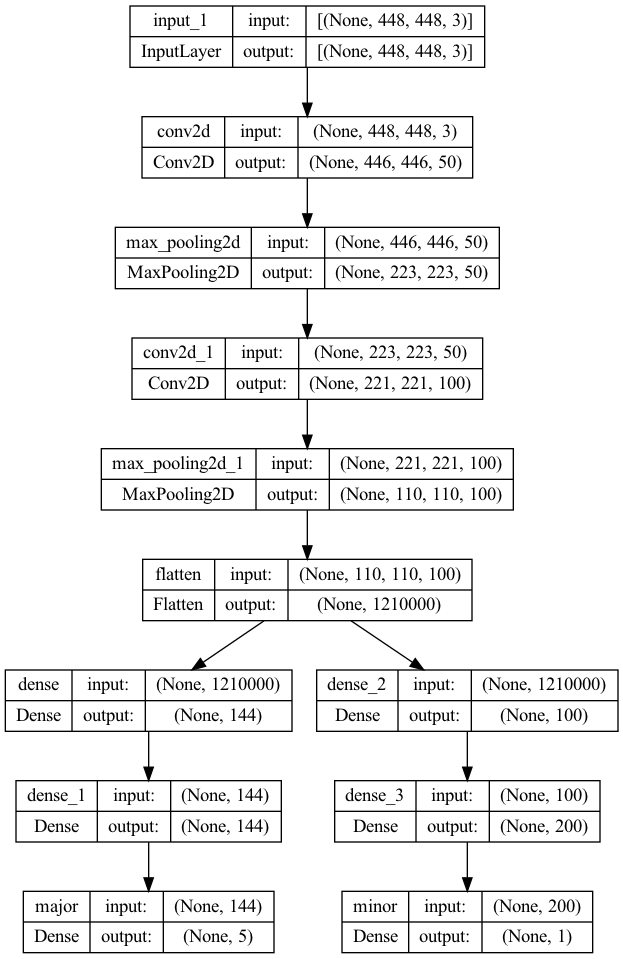

In [28]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [29]:
history_1 =  model.fit(X_train, [y_class_train, y_train],
                       epochs=5,
                       batch_size=32,
                       validation_data=(X_test, [y_class_test, y_test]))

2022-08-28 22:45:12.933661: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2022-08-28 22:45:14.964590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 138.4281 - major_loss: 7.6031 - minor_loss: 130.8249 - major_accuracy: 0.3685 - major_mae: 0.8090 - minor_accuracy: 0.1180 - minor_mae: 2.5099

2022-08-28 22:47:06.881493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 127s 2s/step - loss: 138.4281 - major_loss: 7.6031 - minor_loss: 130.8249 - major_accuracy: 0.3685 - major_mae: 0.8090 - minor_accuracy: 0.1180 - minor_mae: 2.5099 - val_loss: 1.4481 - val_major_loss: 1.2054 - val_minor_loss: 0.2427 - val_major_accuracy: 0.4297 - val_major_mae: 0.8674 - val_minor_accuracy: 0.1034 - val_minor_mae: 0.4086
Epoch 2/5
48/48 [==============================] - 160s 3s/step - loss: 1.3500 - major_loss: 1.1101 - minor_loss: 0.2399 - major_accuracy: 0.4732 - major_mae: 0.8090 - minor_accuracy: 0.1252 - minor_mae: 0.4015 - val_loss: 1.3784 - val_major_loss: 1.1410 - val_minor_loss: 0.2375 - val_major_accuracy: 0.4297 - val_major_mae: 0.8674 - val_minor_accuracy: 0.1034 - val_minor_mae: 0.3998
Epoch 3/5
48/48 [==============================] - 158s 3s/step - loss: 1.3238 - major_loss: 1.0956 - minor_loss: 0.2282 - major_accuracy: 0.4732 - major_mae: 0.8090 - minor_accuracy: 0.1252 - minor_mae: 0.3885 - val_loss: 1.3901 - va

In [30]:
# history_2 =  model.fit(X_train, [y_class_train, y_train],
#                        epochs=30,
#                        batch_size=32,
#                        validation_data=(X_test, [y_class_test, y_test]))

In [31]:
# Non-normalized
# history_3 =  model.fit(X_train1, [y_class_train1, y_train1],
#                        epochs=5,
#                        batch_size=32,
#                        validation_data=(X_test1, [y_class_test1, y_test1]))

In [32]:
# Non-normalized
# history_3 =  model.fit(X_train1, [y_class_train1, y_train1],
#                        epochs=30,
#                        batch_size=32,
#                        validation_data=(X_test1, [y_class_test1, y_test1]))

#### Model3

In [33]:
#Create model3
input = Input(shape = (448,448,3))
conv1 = Conv2D(10,3,activation='relu')(input)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(10,3,activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(10,3,activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

flat = Flatten()(pool3)

major = Dense(5, activation='softmax', name="major")(flat)

minor = Dense(1, activation='linear', name="minor")(flat)

model3 = Model(inputs=input, outputs=[major, minor])

In [34]:
adam = tf.keras.optimizers.Adam(learning_rate=.001)
model3.compile(loss=["sparse_categorical_crossentropy", "mse"], 
               optimizer=adam,
               metrics=["accuracy", "mae"])

In [35]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 446, 446, 10  280         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 223, 223, 10  0          ['conv2d_4[0][0]']               
                                )                                                           

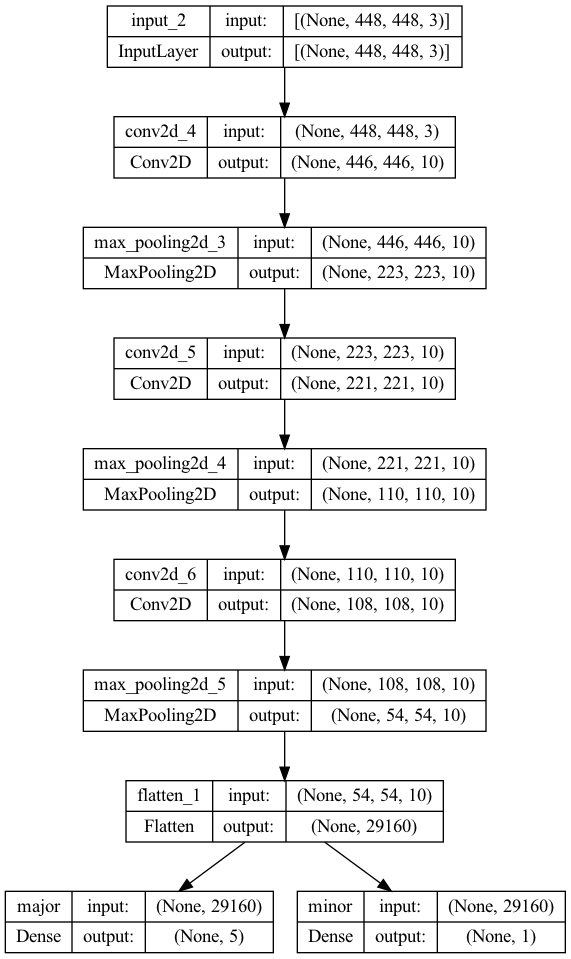

In [36]:
plot_model(model3, show_shapes=True, show_layer_names=True)

In [37]:
# Fit model3
history_3 =  model3.fit(X_train, [y_class_train, y_train],
                       epochs=5,
                       batch_size=32,
                       validation_data=(X_test, [y_class_test, y_test]))

Epoch 1/5


2022-08-28 22:58:49.969441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 1.7080 - major_loss: 1.1773 - minor_loss: 0.5307 - major_accuracy: 0.4480 - major_mae: 0.8090 - minor_accuracy: 0.1186 - minor_mae: 0.5386

2022-08-28 22:59:11.178273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 23s 467ms/step - loss: 1.7080 - major_loss: 1.1773 - minor_loss: 0.5307 - major_accuracy: 0.4480 - major_mae: 0.8090 - minor_accuracy: 0.1186 - minor_mae: 0.5386 - val_loss: 1.3513 - val_major_loss: 1.1122 - val_minor_loss: 0.2391 - val_major_accuracy: 0.4589 - val_major_mae: 0.8674 - val_minor_accuracy: 0.0955 - val_minor_mae: 0.3910
Epoch 2/5
48/48 [==============================] - 30s 632ms/step - loss: 1.2392 - major_loss: 1.0192 - minor_loss: 0.2200 - major_accuracy: 0.5063 - major_mae: 0.8090 - minor_accuracy: 0.1199 - minor_mae: 0.3776 - val_loss: 1.2559 - val_major_loss: 1.0281 - val_minor_loss: 0.2278 - val_major_accuracy: 0.5119 - val_major_mae: 0.8674 - val_minor_accuracy: 0.1034 - val_minor_mae: 0.3873
Epoch 3/5
48/48 [==============================] - 27s 564ms/step - loss: 1.1108 - major_loss: 0.9134 - minor_loss: 0.1974 - major_accuracy: 0.6110 - major_mae: 0.8090 - minor_accuracy: 0.1173 - minor_mae: 0.3544 - val_loss: 1.1531 - 

#### Model4

In [38]:
model4 = tf.keras.models.clone_model(model3)

adam = tf.keras.optimizers.Adam(learning_rate=.001)
model4.compile(loss=["sparse_categorical_crossentropy", "mse"], 
               optimizer=adam,
               metrics=["accuracy", "mae"])

In [39]:
model4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 446, 446, 10  280         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 223, 223, 10  0          ['conv2d_4[0][0]']               
                                )                                                           

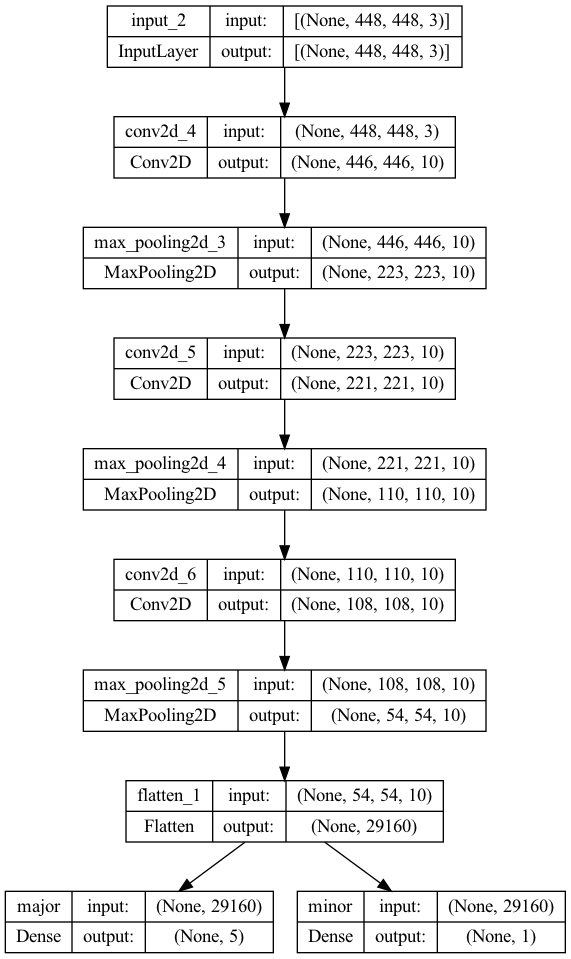

In [40]:
plot_model(model4, show_shapes=True, show_layer_names=True)

In [41]:
history_4 =  model4.fit(X_train, [y_class_train, y_train],
                       epochs=30,
                       batch_size=32,
                       validation_data=(X_test, [y_class_test, y_test]))

Epoch 1/30


2022-08-28 23:01:35.013677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 1.6920 - major_loss: 1.1645 - minor_loss: 0.5275 - major_accuracy: 0.4467 - major_mae: 0.8090 - minor_accuracy: 0.1173 - minor_mae: 0.5352

2022-08-28 23:01:55.723836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 23s 461ms/step - loss: 1.6920 - major_loss: 1.1645 - minor_loss: 0.5275 - major_accuracy: 0.4467 - major_mae: 0.8090 - minor_accuracy: 0.1173 - minor_mae: 0.5352 - val_loss: 1.3436 - val_major_loss: 1.1137 - val_minor_loss: 0.2299 - val_major_accuracy: 0.4297 - val_major_mae: 0.8674 - val_minor_accuracy: 0.1034 - val_minor_mae: 0.3914
Epoch 2/30
48/48 [==============================] - 27s 577ms/step - loss: 1.2563 - major_loss: 1.0338 - minor_loss: 0.2226 - major_accuracy: 0.5123 - major_mae: 0.8090 - minor_accuracy: 0.1206 - minor_mae: 0.3832 - val_loss: 1.2529 - val_major_loss: 1.0349 - val_minor_loss: 0.2180 - val_major_accuracy: 0.5358 - val_major_mae: 0.8674 - val_minor_accuracy: 0.1034 - val_minor_mae: 0.3756
Epoch 3/30
48/48 [==============================] - 25s 526ms/step - loss: 1.1219 - major_loss: 0.9273 - minor_loss: 0.1946 - major_accuracy: 0.5838 - major_mae: 0.8090 - minor_accuracy: 0.1199 - minor_mae: 0.3492 - val_loss: 1.1316 

#### Model5

In [42]:
#Create model5
input = Input(shape = (448,448,3))
conv1 = Conv2D(10,3,activation='relu')(input)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
batch1 = BatchNormalization()(pool1)

conv2 = Conv2D(10,3,activation='relu')(batch1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
batch2 = BatchNormalization()(pool2)

conv3 = Conv2D(10,3,activation='relu')(batch2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

flat = Flatten()(pool3)

major = Dense(5, activation='softmax', name="major")(flat)

minor = Dense(1, activation='linear', name="minor")(flat)

model5 = Model(inputs=input, outputs=[major, minor])

In [43]:
model5.compile(loss=["sparse_categorical_crossentropy", "mse"], 
               optimizer=adam,
               metrics=["accuracy", "mae"])

In [44]:
model5.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 446, 446, 10  280         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 223, 223, 10  0          ['conv2d_7[0][0]']               
                                )                                                           

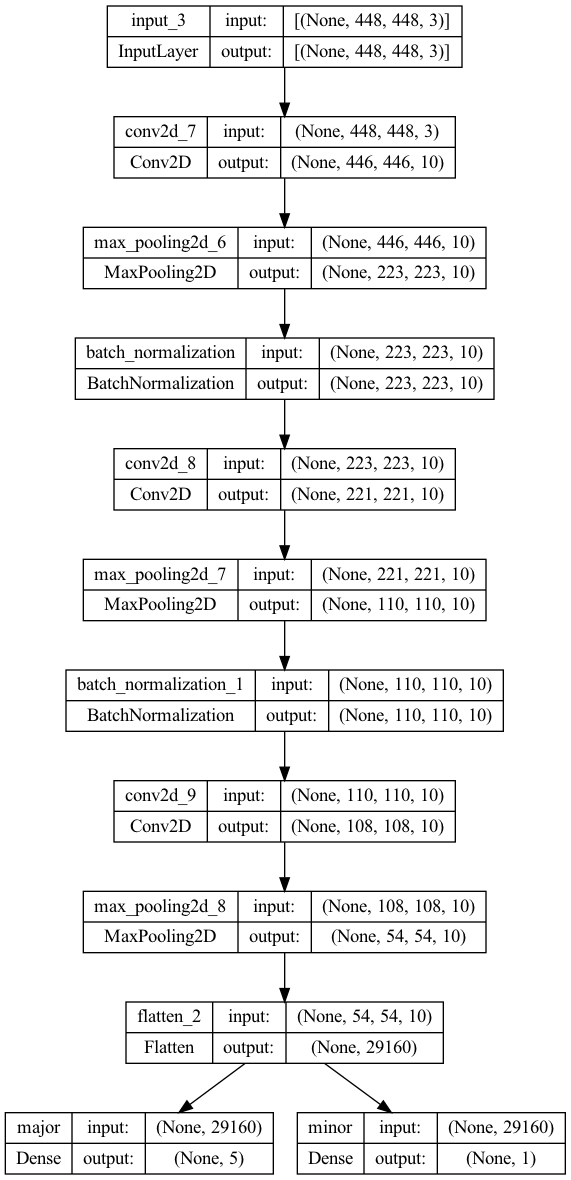

In [45]:
plot_model(model5, show_shapes=True, show_layer_names=True)

In [46]:
history_5 =  model5.fit(X_train, [y_class_train, y_train],
                       epochs=30,
                       batch_size=32,
                       validation_data=(X_test, [y_class_test, y_test]))

Epoch 1/30


2022-08-28 23:13:43.018938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 168.5942 - major_loss: 10.4030 - minor_loss: 158.1911 - major_accuracy: 0.3439 - major_mae: 0.8090 - minor_accuracy: 0.0755 - minor_mae: 6.6692

2022-08-28 23:14:03.478674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 22s 451ms/step - loss: 168.5942 - major_loss: 10.4030 - minor_loss: 158.1911 - major_accuracy: 0.3439 - major_mae: 0.8090 - minor_accuracy: 0.0755 - minor_mae: 6.6692 - val_loss: 53.9431 - val_major_loss: 11.3929 - val_minor_loss: 42.5502 - val_major_accuracy: 0.2785 - val_major_mae: 0.8674 - val_minor_accuracy: 0.1034 - val_minor_mae: 6.4039
Epoch 2/30
48/48 [==============================] - 30s 630ms/step - loss: 2.1278 - major_loss: 1.5275 - minor_loss: 0.6003 - major_accuracy: 0.4811 - major_mae: 0.8090 - minor_accuracy: 0.0901 - minor_mae: 0.6125 - val_loss: 7.1762 - val_major_loss: 3.3011 - val_minor_loss: 3.8751 - val_major_accuracy: 0.2785 - val_major_mae: 0.8674 - val_minor_accuracy: 0.1034 - val_minor_mae: 1.8152
Epoch 3/30
48/48 [==============================] - 29s 591ms/step - loss: 1.1766 - major_loss: 0.8915 - minor_loss: 0.2851 - major_accuracy: 0.6024 - major_mae: 0.8090 - minor_accuracy: 0.1027 - minor_mae: 0.4264 - val_loss:

In [47]:
# Plot the validation and training curve separately
def plot_loss_curve(history):
  """
  Returns separate loss curve for training and validation metrics
  """
  major_loss = history.history["major_loss"]
  val_major_loss = history.history["val_major_loss"]

  major_accuracy = history.history["major_accuracy"]
  val_major_accuracy = history.history["val_major_accuracy"]

  epochs = range(len(history.history["major_loss"])) 

  # Plot loss 
  plt.plot(epochs, major_loss, label="training_loss")
  plt.plot(epochs, val_major_loss, label="val_major_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, major_accuracy, label="training_major_accuracy")
  plt.plot(epochs, val_major_accuracy, label="val_major_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

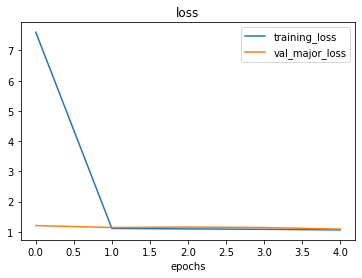

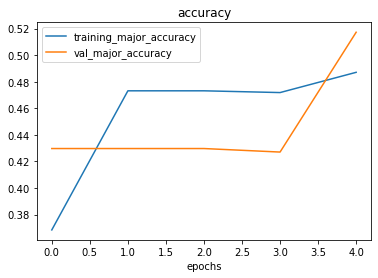

In [48]:
plot_loss_curve(history_1)

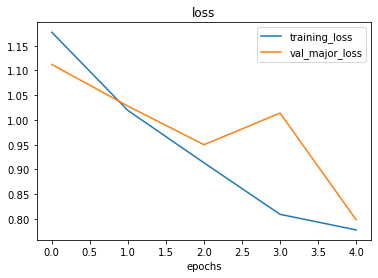

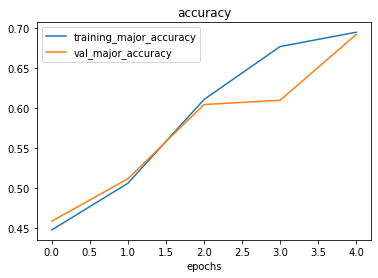

In [49]:
plot_loss_curve(history_3)

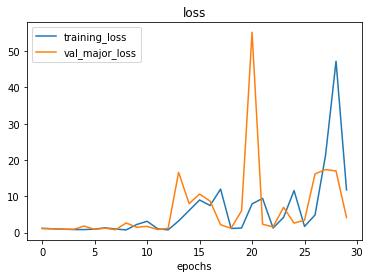

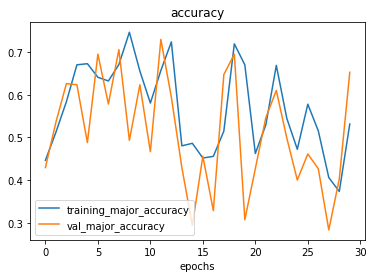

In [50]:
plot_loss_curve(history_4)

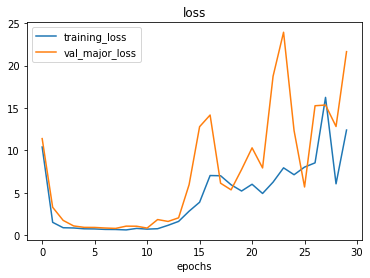

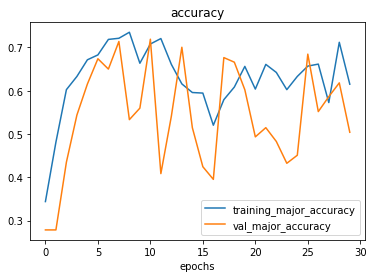

In [51]:
plot_loss_curve(history_5)

In [52]:
y_probs = model4.predict(X_test)
y_preds = y_probs[0].argmax(axis=-1)
accuracy_score(y_class_test, y_preds)

 1/12 [=>............................] - ETA: 3s

2022-08-28 23:26:32.364308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 90ms/step


0.6525198938992043

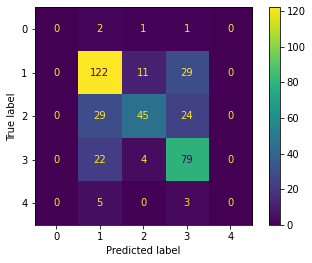

In [53]:
cm = confusion_matrix(y_class_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

### Ensemble Deep Learning Model

In [54]:
# Create template model
model6 = tf.keras.models.clone_model(model4)

In [55]:
nets = 10
models = []
adam = tf.keras.optimizers.Adam(learning_rate=.001)
for i in range(nets):
    models.append(model6)

    # Compile each model
    models[i].compile(loss=["sparse_categorical_crossentropy", "mse"], 
                      optimizer=adam,
                      metrics=["accuracy", "mae"])
   

In [56]:
np.unique(y_class_test)

array([-1.,  0.,  1.,  2.,  3.])

In [57]:
unique, counts = np.unique(y_class_test, return_counts=True)
dict(zip(unique, counts))

{-1.0: 4, 0.0: 162, 1.0: 98, 2.0: 105, 3.0: 8}

In [70]:
for j in range(nets):
    print(f'Individual Net : {j+1}')

    es = EarlyStopping(monitor='val_major_acc', mode='max', verbose=1)
    models[j].fit(X_train, [y_class_train, y_train],
                  epochs=30,
                  batch_size=32,
                  validation_data=(X_test, [y_class_test, y_test]),
                  verbose=0)
    # models[j].save("../Gauge_classification/models/model{0}.h5".format(j))
    y_probs = models[i].predict(X_test)
    y_preds = y_probs[0].argmax(axis=-1)
    acc = accuracy_score(y_class_test, y_preds)

    y_preds2 = y_probs[1]
    error1 = mean_absolute_error(y_test, y_preds2)

    print("Accuracy : ", acc, "\nMAE : ", error1)


Individual Net : 1


2022-08-29 00:24:22.052696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 104ms/step
Accuracy :  0.41114058355437666 
MAE :  8.569705803585622
Individual Net : 2
12/12 [==============================] - 1s 115ms/step
Accuracy :  0.7586206896551724 
MAE :  9.829967407514625
Individual Net : 3
12/12 [==============================] - 1s 94ms/step
Accuracy :  0.5543766578249337 
MAE :  102.97984711320711
Individual Net : 4
12/12 [==============================] - 1s 107ms/step
Accuracy :  0.7559681697612732 
MAE :  11.30051896217173
Individual Net : 5


: 

: 

In [1]:
model4.save("../Gauge_classification/models/model4.h5")

NameError: name 'model4' is not defined